In [38]:
import pandas as pd

temp_list = []

with open("train_call.txt", 'r') as temp:
    for line in temp:
        temp_list.append(line.split())

columns_temp = temp_list[0]
columns_temp = [x.replace("\"", "") for x in columns_temp]

df_train = pd.DataFrame(temp_list[1:], columns=columns_temp)
X = df_train.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
X = X.transpose()

labels = []

# X for features Y for breast cancer subtype where 1 = HER2+, 2 = HR+, 3 = Triple Neg
with open("Train_clinical.txt", 'r') as temp_labels:
    next(temp_labels)
    for line in temp_labels:
        temp = line.strip()
        temp = temp.split()
        if temp[1].strip("\"") == "HER2+":
            labels.append(1)
        if temp[1].strip("\"") == "HR+":
            labels.append(2)
        if temp[1].strip("\"") == "Triple":
            labels.append(3)

Y = labels
            
important_genes = []

with open("important_genes_2.csv", 'r') as imp_genes:
    for line in imp_genes:
        temp = line.strip()
        important_genes.append(temp.split(","))
        
imp_genes = []

for gene in important_genes[1:]:
    imp_genes.append([gene[0], gene[1], gene[2], gene[3]])
    
important_genes = []

for x in imp_genes:
    for i, y in enumerate(df_train.values.tolist()):
        if x[1] == y[0] and x[2] == y[1] and x[3] == y[2]:
            important_genes.append(i)
            
print(X)
print(Y)
print("The regions found in the literature were: ", important_genes)

          0    1    2    3    4    5    6    7    8    9     ... 2824 2825  \
Array.129    0    0    0    0    0    0    0    0    0    0  ...    2    2   
Array.34     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.67     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.24     0    0    0    0    0    0    0   -1    0    0  ...    0    0   
Array.22     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.36     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.49     0    0    0    0    0    0    0    0    0    0  ...    2    1   
Array.16     0    0    0    0   -1    0    0    0    0    0  ...    1    1   
Array.146    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.143    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.65     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.62     1    1    1    1    1    1    1    1    1    1  ...

In [40]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# #Loading data
patients = X.values.tolist()

## FEATURE SELECTION

# we need to shift the features by 1 since the chi2 function does not take non-negative values
patients_shift = []

for patient in patients:
    x = []
    for feature in patient:
        x.append(int(feature) + 1)
    patients_shift.append(x)

chi, p_val = chi2(patients_shift, Y)

imp_genes_p_values = []

for i, j in enumerate(important_genes):
    if p_val[j] >= 0.05:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "No"])
    else:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "Yes"])
    

important_genes_scores = pd.DataFrame(imp_genes_p_values, columns=["Gene", "Region number", "P-value", "Yes/No"])
pd.set_option('display.max_rows', 75)
print(important_genes_scores)

X_feature_selected = X

significant_features = []

threshold = 0.05
for i, val in enumerate(p_val):
    # this drops the p_values higher than 0.05 that are not in the significant genes list
    gene_temp = df_train.iloc[i].values.tolist()
    
    if val >= threshold and i not in important_genes or int(gene_temp[3]) < 10:
        X_feature_selected = X_feature_selected.drop([i], axis=1)
    else:
        significant_features.append([gene_temp[0], gene_temp[1], gene_temp[2], gene_temp[3]])
        
sig_features_df = pd.DataFrame(significant_features, columns=["Chromosome", "Start", "End", "Nclone"])
pd.set_option('display.max_rows', 204)
print(sig_features_df)

                 Gene  Region number       P-value Yes/No
0              DIRAS3            111  6.897062e-01     No
1              PTPN22            157  7.287985e-01     No
2                 AGT            249  9.791761e-01     No
3               CLSPN             65  5.039604e-01     No
4   BARD1/CASP8/CTLA4            361  8.022867e-01     No
5               SF3B1            360  8.717109e-01     No
6              PIK3CA            479  4.007464e-01     No
7               NFKB1            576  8.076397e-01     No
8                FGF2            583  8.076397e-01     No
9               RAD50            688  1.138701e-01     No
10             MAP3K1            664  1.569463e-01     No
11               TERT            625  9.757757e-01     No
12             PIK3R1            670  4.250528e-02    Yes
13              CCND3            772  1.568220e-01     No
14               ESR1            876  4.297669e-01     No
15               ESR1            877  3.435048e-01     No
16            

In [41]:
X = X_feature_selected
number_of_features = len(X.values.tolist()[0])
print("Number of features = {}".format(number_of_features))

Number of features = 164


In [42]:
X = X[2184]

In [43]:
X = X.values.tolist()

In [44]:
new_X = X
X = []
for val in new_X:
    X.append(int(val))

In [45]:
X = np.array(X)


In [49]:
X = X.reshape(-1, 1)

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

def classification_report_with_accuracy_score(y_true, y_pred):
    "Scorer for the cross validation function"
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) 

def evaluate_model(model, features, labels):
    "Gets the cross validation score using a 5-fold (cv=5) cross validation"
    scores = cross_val_score(model, features, labels, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))
    
    return scores

In [51]:
def nested_cross_validation(MODEL, PARAMS, X, Y, NUM_TRIALS):
    model_scores = np.zeros(NUM_TRIALS)
    model_params = {}
    nested_scores = []
    
    for i in range(NUM_TRIALS):
        print("Running Trial {}...".format(i + 1))
        inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        
        model = GridSearchCV(estimator=MODEL, param_grid=PARAMS, cv=inner_cv, n_jobs=2)
        model.fit(X, Y)
        print(model.score(X, Y), model.best_params_)
        model_scores[i] = model.score(X, Y)
        model_params[i] = model.best_params_
        
        nested_score = cross_val_score(model, X=X, y=Y, cv=outer_cv)
        nested_scores.append([nested_score.mean(), nested_score.std()])
        print(nested_score.mean(), nested_score.std())
        
    return model_scores, model_params, nested_scores

In [54]:
parameters = {'solver': ['lbfgs'], 
              'max_iter': [500, 1000, 1500, 2000], 
              'hidden_layer_sizes':np.linspace(1, 10, 10, dtype=int)
             }

mlp = MLPClassifier()

mlp_scores, mlp_params, mlp_nested = nested_cross_validation(mlp, parameters, X, Y, 100)

Running Trial 1...
0.69 {'hidden_layer_sizes': 3, 'max_iter': 1000, 'solver': 'lbfgs'}
0.63 0.06557438524302002
Running Trial 2...
0.69 {'hidden_layer_sizes': 2, 'max_iter': 1500, 'solver': 'lbfgs'}
0.5 0.14
Running Trial 3...
0.69 {'hidden_layer_sizes': 3, 'max_iter': 500, 'solver': 'lbfgs'}
0.69 0.01732050807568874
Running Trial 4...
0.69 {'hidden_layer_sizes': 1, 'max_iter': 2000, 'solver': 'lbfgs'}
0.66 0.044721359549995794
Running Trial 5...
0.68 {'hidden_layer_sizes': 4, 'max_iter': 500, 'solver': 'lbfgs'}
0.58 0.14
Running Trial 6...
0.69 {'hidden_layer_sizes': 3, 'max_iter': 2000, 'solver': 'lbfgs'}
0.55 0.11445523142259598
Running Trial 7...
0.69 {'hidden_layer_sizes': 3, 'max_iter': 500, 'solver': 'lbfgs'}
0.47 0.1109053650640942
Running Trial 8...
0.68 {'hidden_layer_sizes': 2, 'max_iter': 500, 'solver': 'lbfgs'}
0.66 0.020000000000000018
Running Trial 9...
0.69 {'hidden_layer_sizes': 4, 'max_iter': 500, 'solver': 'lbfgs'}
0.6699999999999999 0.04358898943540674
Running Trial

0.69 {'hidden_layer_sizes': 1, 'max_iter': 500, 'solver': 'lbfgs'}
0.67 0.04358898943540674
Running Trial 73...
0.69 {'hidden_layer_sizes': 2, 'max_iter': 1000, 'solver': 'lbfgs'}
0.6500000000000001 0.05196152422706632
Running Trial 74...
0.68 {'hidden_layer_sizes': 2, 'max_iter': 1000, 'solver': 'lbfgs'}
0.65 0.033166247903554026
Running Trial 75...
0.68 {'hidden_layer_sizes': 2, 'max_iter': 2000, 'solver': 'lbfgs'}
0.5900000000000001 0.1396424004376894
Running Trial 76...
0.68 {'hidden_layer_sizes': 1, 'max_iter': 1000, 'solver': 'lbfgs'}
0.5900000000000001 0.13379088160259656
Running Trial 77...
0.69 {'hidden_layer_sizes': 3, 'max_iter': 500, 'solver': 'lbfgs'}
0.67 0.033166247903553984
Running Trial 78...
0.69 {'hidden_layer_sizes': 4, 'max_iter': 1000, 'solver': 'lbfgs'}
0.44999999999999996 0.09110433579144302
Running Trial 79...
0.69 {'hidden_layer_sizes': 2, 'max_iter': 500, 'solver': 'lbfgs'}
0.5700000000000001 0.12449899597988735
Running Trial 80...
0.68 {'hidden_layer_sizes':

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10, dtype=int)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features}

rf = RandomForestClassifier()

rf_scores, rf_params, rf_nested = nested_cross_validation(rf, parameters, X, Y, 100)

Running Trial 1...
0.69 {'max_features': 'auto', 'n_estimators': 22}
0.62 0.060000000000000005
Running Trial 2...
0.69 {'max_features': 'auto', 'n_estimators': 22}
0.68 0.028284271247461888
Running Trial 3...
0.69 {'max_features': 'sqrt', 'n_estimators': 39}
0.67 0.01732050807568879
Running Trial 4...
0.69 {'max_features': 'auto', 'n_estimators': 11}
0.63 0.01732050807568879
Running Trial 5...
0.66 {'max_features': 'auto', 'n_estimators': 1}
0.65 0.1244989959798873
Running Trial 6...
0.69 {'max_features': 'sqrt', 'n_estimators': 6}
0.6300000000000001 0.043588989435406726
Running Trial 7...
0.66 {'max_features': 'sqrt', 'n_estimators': 1}
0.64 0.040000000000000036
Running Trial 8...
0.69 {'max_features': 'auto', 'n_estimators': 1}
0.6400000000000001 0.04898979485566356
Running Trial 9...
0.66 {'max_features': 'auto', 'n_estimators': 1}
0.63 0.06557438524302002
Running Trial 10...
0.69 {'max_features': 'sqrt', 'n_estimators': 33}
0.6300000000000001 0.06557438524302002
Running Trial 11...

0.63 0.051961524227066326
Running Trial 84...
0.69 {'max_features': 'sqrt', 'n_estimators': 50}
0.65 0.07141428428542847
Running Trial 85...
0.69 {'max_features': 'sqrt', 'n_estimators': 28}
0.69 0.043588989435406726
Running Trial 86...
0.69 {'max_features': 'sqrt', 'n_estimators': 6}
0.68 0.028284271247461888
Running Trial 87...
0.68 {'max_features': 'sqrt', 'n_estimators': 1}
0.5800000000000001 0.04472135954999579
Running Trial 88...
0.68 {'max_features': 'auto', 'n_estimators': 1}
0.63 0.059160797830996134
Running Trial 89...
0.69 {'max_features': 'sqrt', 'n_estimators': 28}
0.6500000000000001 0.05916079783099614
Running Trial 90...
0.69 {'max_features': 'sqrt', 'n_estimators': 33}
0.62 0.08246211251235319
Running Trial 91...
0.69 {'max_features': 'auto', 'n_estimators': 11}
0.5900000000000001 0.03316624790355398
Running Trial 92...
0.69 {'max_features': 'auto', 'n_estimators': 39}
0.65 0.01732050807568879
Running Trial 93...
0.69 {'max_features': 'auto', 'n_estimators': 1}
0.590000

In [56]:
params = {
          "var_smoothing" : [1e-5, 1e-9]
}
nb = GaussianNB()

nb_scores, nb_params, nb_nested = nested_cross_validation(nb, params, X, Y, 100)

Running Trial 1...
0.69 {'var_smoothing': 1e-05}
0.63 0.06557438524302002
Running Trial 2...
0.69 {'var_smoothing': 1e-05}
0.66 0.0447213595499958
Running Trial 3...
0.69 {'var_smoothing': 1e-05}
0.6799999999999999 0.028284271247461888
Running Trial 4...
0.69 {'var_smoothing': 1e-05}
0.67 0.033166247903553984
Running Trial 5...
0.69 {'var_smoothing': 1e-05}
0.5900000000000001 0.05916079783099616
Running Trial 6...
0.69 {'var_smoothing': 1e-05}
0.6300000000000001 0.043588989435406726
Running Trial 7...
0.69 {'var_smoothing': 1e-05}
0.64 0.040000000000000036
Running Trial 8...
0.69 {'var_smoothing': 1e-05}
0.6400000000000001 0.04898979485566356
Running Trial 9...
0.69 {'var_smoothing': 1e-05}
0.6699999999999999 0.04358898943540674
Running Trial 10...
0.69 {'var_smoothing': 1e-05}
0.62 0.07211102550927977
Running Trial 11...
0.69 {'var_smoothing': 1e-05}
0.67 0.01732050807568879
Running Trial 12...
0.69 {'var_smoothing': 1e-05}
0.67 0.04358898943540674
Running Trial 13...
0.69 {'var_smoot

In [47]:
result_list = []
result_columns = ["Model", "Trial", "Parameters", "Accuracy", "Std_dev"]


for i in range(100):
    result_list.append(["NB", i, nb_params[i], nb_nested[i][0], nb_nested[i][1]])
    
nb_df = pd.DataFrame(result_list,columns=result_columns)

nb_df.to_csv("NB_results")

In [44]:
result_list = []
result_columns = ["Model", "Trial", "Parameters", "Accuracy", "Std_dev"]


for i in range(100):
    result_list.append(["MLP", i, mlp_params[i], mlp_nested[i][0], mlp_nested[i][1]])
    
mlp_df = pd.DataFrame(result_list,columns=result_columns)

mlp_df.to_csv("MLP_results")

In [45]:
result_list = []
result_columns = ["Model", "Trial", "Parameters", "Accuracy", "Std_dev"]


for i in range(100):
    result_list.append(["RF", i, rf_params[i], rf_nested[i][0], rf_nested[i][1]])
    
rf_df = pd.DataFrame(result_list,columns=result_columns)

rf_df.to_csv("RF_results")

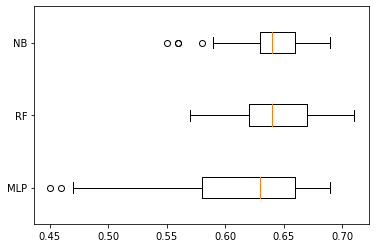

In [57]:
temp1 = np.array(mlp_nested)[:,0] 
temp2 = np.array(rf_nested)[:,0]
temp3 = np.array(nb_nested)[:,0]

# print(temp1)

plt.boxplot([temp1, temp2, temp3], vert=0, labels=['MLP', 'RF', "NB"])
plt.savefig("boxplot.png", dpi=300)
plt.show()

Feature ranking:
1. feature 170 (0.113050)
2. feature 201 (0.016140)
3. feature 181 (0.015683)
4. feature 26 (0.014354)
5. feature 55 (0.014103)
6. feature 3 (0.013284)
7. feature 187 (0.013182)
8. feature 17 (0.013129)
9. feature 198 (0.013081)
10. feature 123 (0.013056)
11. feature 185 (0.012242)
12. feature 188 (0.011577)
13. feature 113 (0.011234)
14. feature 41 (0.010344)
15. feature 179 (0.010288)
16. feature 122 (0.010015)
17. feature 121 (0.009961)
18. feature 136 (0.009958)
19. feature 29 (0.009850)
20. feature 18 (0.009226)
21. feature 4 (0.009071)
22. feature 186 (0.008986)
23. feature 129 (0.008790)
24. feature 199 (0.008763)
25. feature 31 (0.008748)
26. feature 54 (0.008368)
27. feature 115 (0.007871)
28. feature 174 (0.007802)
29. feature 197 (0.007720)
30. feature 140 (0.007683)
31. feature 19 (0.007662)
32. feature 138 (0.007483)
33. feature 114 (0.007390)
34. feature 200 (0.007148)
35. feature 139 (0.007107)
36. feature 33 (0.006964)
37. feature 47 (0.006854)
38. feat

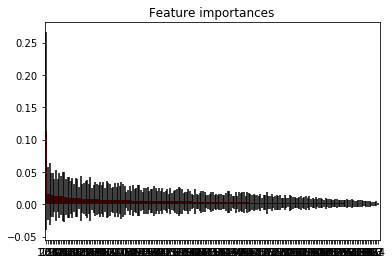

NameError: name 'pr' is not defined

In [28]:
# Random Forest

originalclass = []
predictedclass = []

forest = RandomForestClassifier(n_estimators=100)
# temp = evaluate_model(random_forest, X, Y)

forest.fit(X, Y)
# print(random_forest.feature_importances_.max())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
print(classification_report(originalclass, pr/edictedclass)) 

In [75]:
# Random Forest

originalclass = []
predictedclass = []

forest = RandomForestClassifier(n_estimators=100)
temp = evaluate_model(forest, X, Y)
print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           1       0.85      0.88      0.86        32
           2       0.70      0.72      0.71        36
           3       0.70      0.66      0.68        32

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



In [37]:
# Naive Bayes

originalclass = []
predictedclass = []

gnb = GaussianNB()
gnb.fit(X, Y)
print(gnb.coefs_)

# temp = evaluate_model(gnb, X, Y)
# print(classification_report(originalclass, predictedclass))

AttributeError: 'GaussianNB' object has no attribute 'coefs_'

In [76]:
# Neural network with 1 hidden layer (the hidden layer is as big as the number of features)

originalclass = []
predictedclass = []

mlp = MLPClassifier(solver='lbfgs', activation="relu", alpha=0.0001,
                    hidden_layer_sizes=(142,), max_iter=1000)

temp = evaluate_model(mlp, X, Y)
print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

           1       1.00      0.91      0.95        32
           2       0.71      0.83      0.77        36
           3       0.76      0.69      0.72        32

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



In [ ]:
# Neural network with 2 hidden layer (the hidden layer is as big as the number of features)

originalclass = []
predictedclass = []

mlp = MLPClassifier(solver='lbfgs', activation="relu", alpha=1e-5,
                    hidden_layer_sizes=(number_of_features, number_of_features), max_iter=1000)

temp = evaluate_model(mlp, X, Y)
print(classification_report(originalclass, predictedclass))

In [ ]:
# Neural network with 3 hidden layer (the hidden layer is as big as the number of features)

originalclass = []
predictedclass = []

mlp = MLPClassifier(solver='lbfgs', activation="relu", alpha=1e-5,
                    hidden_layer_sizes=(number_of_features, number_of_features, number_of_features,), max_iter=1000)

temp = evaluate_model(mlp, X, Y)
print(classification_report(originalclass, predictedclass))